## "What can you tell me about my machine performance?"

In [2]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn preprocessing & model selection
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV

# Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.tree import _tree

# Evaluation metrics
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    roc_auc_score, 
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_recall_curve,
    auc
)

# Resampling (for class imbalance handling)
from sklearn.utils import resample

# For class feature importance
import shap

In [3]:
#Reading the dataset
df = pd.read_csv("sample_interview_dataset.csv")
df

,UID,Machine Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type,Timestamp
0,M14860,x1,298.1,308.6,1551.0,42.8,0,0,No Failure,2001-12-01 00:00:00
1,L47181,x_1,298.2,308.7,1408.0,46.3,3,0,No Failure,2001-12-01 01:00:00
2,L47182,x_1,298.1,308.5,1498.0,49.4,5,0,No Failure,2001-12-01 02:00:00
3,L47183,x_1,298.2,308.6,1433.0,39.5,7,0,No Failure,2001-12-01 03:00:00
4,L47184,x_1,298.2,308.7,1408.0,40.0,9,0,No Failure,2001-12-01 04:00:00
...,...,...,...,...,...,...,...,...,...,...
9995,M24855,x1,298.8,308.4,1604.0,29.5,14,0,No Failure,2003-01-21 11:00:00
9996,H39410,X1,298.9,308.4,1632.0,31.8,17,0,No Failure,2003-01-21 12:00:00
9997,M24857,x1,299.0,308.6,1645.0,33.4,22,0,No Failure,2003-01-21 13:00:00
9998,H39412,X1,299.0,308.7,1408.0,48.5,25,0,No Failure,2003-01-21 14:00:00


### Exploratory Analysis of the Dataset

#### Understanding Our Dataset

In [6]:
df.head()

,UID,Machine Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type,Timestamp
0,M14860,x1,298.1,308.6,1551.0,42.8,0,0,No Failure,2001-12-01 00:00:00
1,L47181,x_1,298.2,308.7,1408.0,46.3,3,0,No Failure,2001-12-01 01:00:00
2,L47182,x_1,298.1,308.5,1498.0,49.4,5,0,No Failure,2001-12-01 02:00:00
3,L47183,x_1,298.2,308.6,1433.0,39.5,7,0,No Failure,2001-12-01 03:00:00
4,L47184,x_1,298.2,308.7,1408.0,40.0,9,0,No Failure,2001-12-01 04:00:00


In [7]:
df.info()

# Note we have 100 missing values from Rotation Speed (rpm) that will be addressed before analsis

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UID                      10000 non-null  object 
 1   Machine Type             10000 non-null  object 
 2   Air temperature [K]      10000 non-null  float64
 3   Process temperature [K]  10000 non-null  float64
 4   Rotational speed [rpm]   9900 non-null   float64
 5   Torque [Nm]              10000 non-null  float64
 6   Tool wear [min]          10000 non-null  int64  
 7   Target                   10000 non-null  int64  
 8   Failure Type             10000 non-null  object 
 9   Timestamp                10000 non-null  object 
dtypes: float64(4), int64(2), object(4)
memory usage: 781.4+ KB


In [8]:
df.describe

<bound method NDFrame.describe of          UID Machine Type  Air temperature [K]  Process temperature [K]  \
0     M14860           x1                298.1                    308.6   
1     L47181          x_1                298.2                    308.7   
2     L47182          x_1                298.1                    308.5   
3     L47183          x_1                298.2                    308.6   
4     L47184          x_1                298.2                    308.7   
...      ...          ...                  ...                      ...   
9995  M24855           x1                298.8                    308.4   
9996  H39410           X1                298.9                    308.4   
9997  M24857           x1                299.0                    308.6   
9998  H39412           X1                299.0                    308.7   
9999  M24859           x1                299.0                    308.7   

      Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Targe

In [9]:
# Understanding the dsitribution of datapoints in catogrical dataset

print(df['Target'].value_counts())
print(df['Machine Type'].value_counts())
print(df['Failure Type'].value_counts())

Target
0    9661
1     339
Name: count, dtype: int64
Machine Type
x_1    5937
x1     2974
X1      989
X2      100
Name: count, dtype: int64
Failure Type
No Failure                  9553
Heat Dissipation Failure     112
Error                        100
Power Failure                 95
Overstrain Failure            78
Tool Wear Failure             45
Random Failures               17
Name: count, dtype: int64


**From the initial EDA we understand that our data has:**
* The data has loaded correctly

* 10,000 entries and 10 columns.

* Mixed datatypes: 4 categorical, 4 numerical (float/int), and 2 identifier/timestamp.

* One column (Rotational speed [rpm]) has missing values (100 missing).

* Target appears to be a binary indicator — possibly failure occurrence.

* We have some class imbalance issues that need to be addressed i.e Target varaible/Failure Type

#### Quality Control

**In this section we examine our data for:**

* Completeness (missing data)
* Duplication
* Anomalous Results

In [12]:
# Examining for missing values (Note: 100 NA values found)
df.isnull().sum()

UID                          0
Machine Type                 0
Air temperature [K]          0
Process temperature [K]      0
Rotational speed [rpm]     100
Torque [Nm]                  0
Tool wear [min]              0
Target                       0
Failure Type                 0
Timestamp                    0
dtype: int64

In [13]:
# We are inserting the median value into the 100 missing values of "rotational speed". Note: Mean is not used here as distibution is skewed to the right

df['Rotational speed [rpm]'] = df['Rotational speed [rpm]'].fillna(df['Rotational speed [rpm]'].median())

df.isnull().sum() # We have solved the missing values in the dataset

UID                        0
Machine Type               0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Target                     0
Failure Type               0
Timestamp                  0
dtype: int64

In [14]:
# Examining for Duplicated Results
df.duplicated().sum()

0

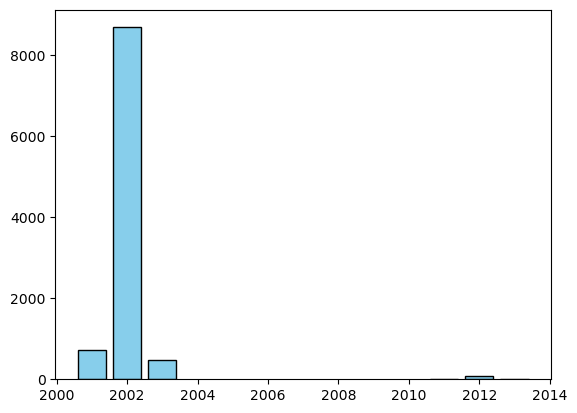

In [15]:
# Checking for anomalous results with timestamp

# Extract year from Timestamp
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df['Year'] = df['Timestamp'].dt.year

# Count frequency of each year
year_counts = df['Year'].value_counts().sort_index()

plt.bar(year_counts.index, year_counts.values, color='skyblue', edgecolor='black')

# We have anomalous results passed 2003 - they need to be removed

df = df[df['Timestamp'].dt.year <= 2003]



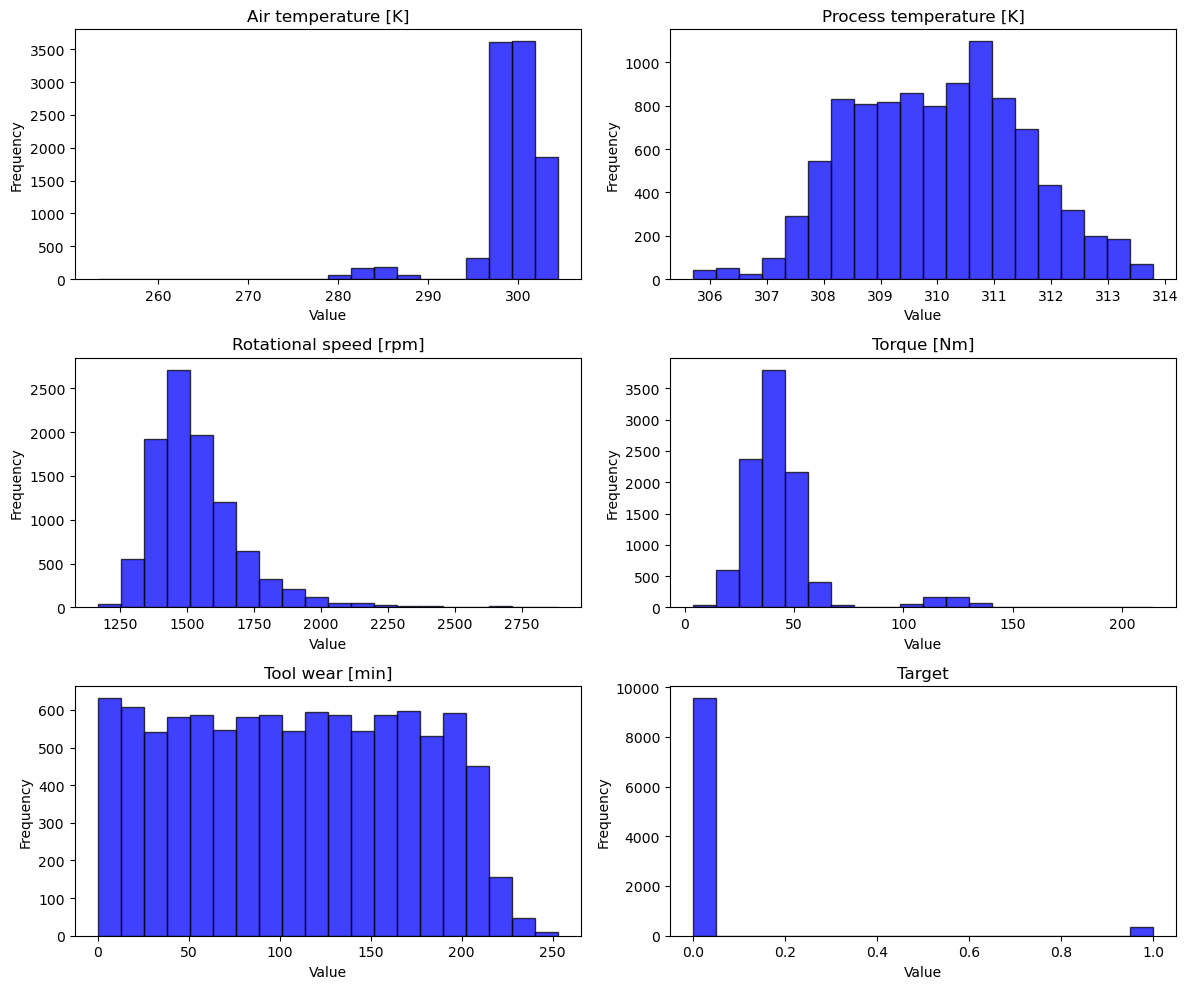

In [16]:
# Visualising the datapoint distributions in Numerical Data
def plot_num_hist(data):
    """
    Plots histograms for numerical features in the dataset.
    """
    # Only include numerical features
    features = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 
                'Torque [Nm]', 'Tool wear [min]', 'Target']
    
    plt.figure(figsize=(12, 10))
    
    for i, feature in enumerate(features, 1):
        plt.subplot(3, 2, i)  # 3 rows, 2 columns
        plt.hist(data[feature].dropna(), bins=20, edgecolor='black', alpha=0.75, color='blue')
        plt.title(feature, fontsize=12)
        plt.xlabel('Value')
        plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

# Call the function
plot_num_hist(df)

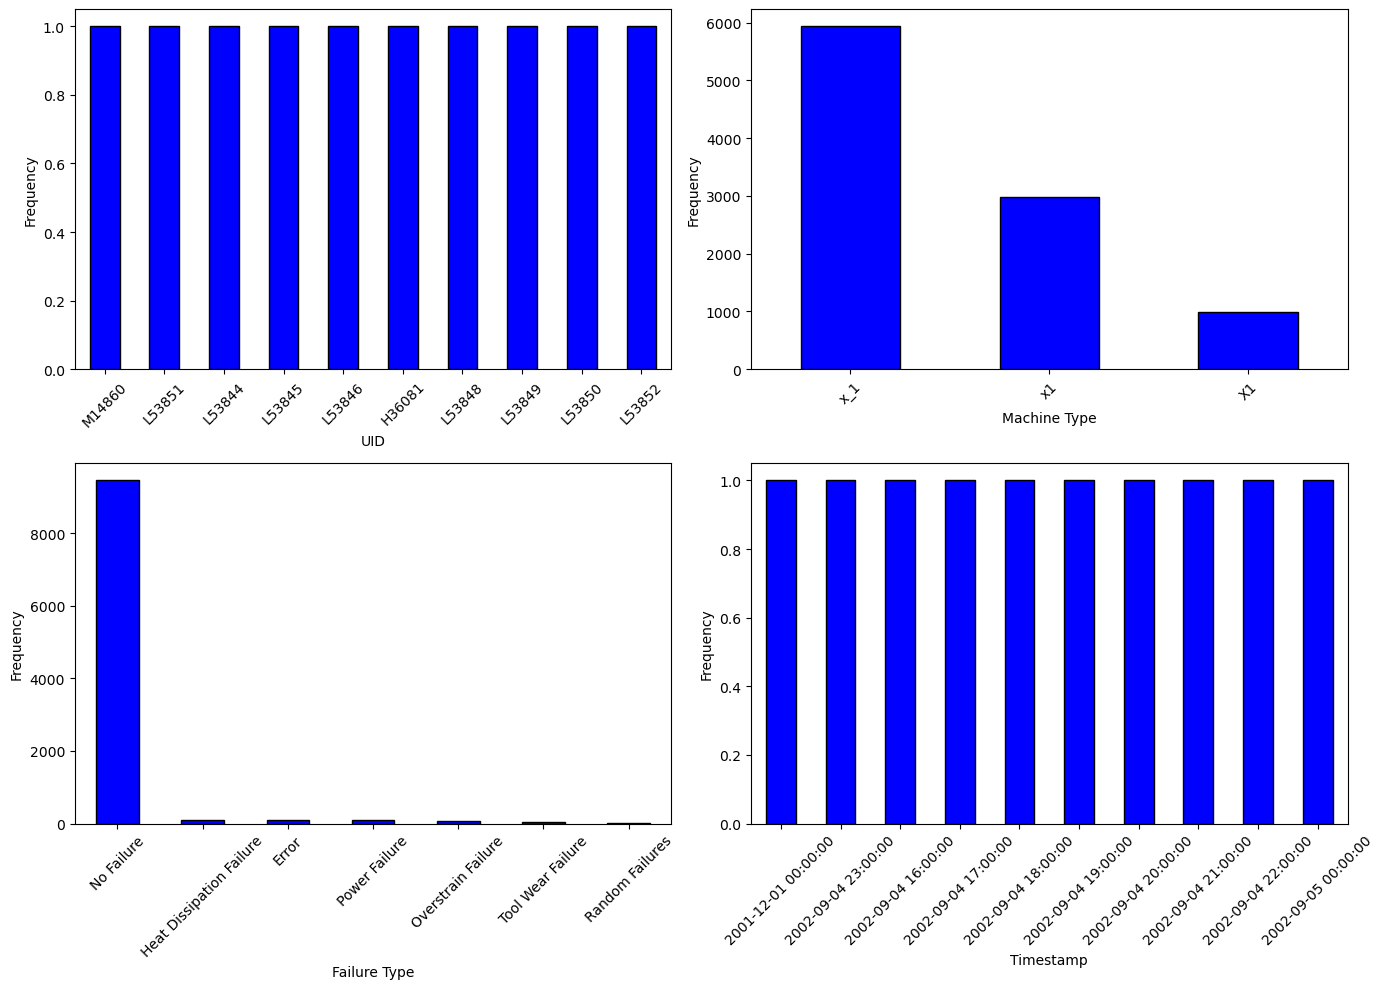

In [17]:
# Visualising the datapoint distributions in Categorical Data
def plot_cat(data):
    """
    Plots bar charts for categorical features in the dataset.
    """
    # Define categorical features
    features = ['UID', 'Machine Type', 'Failure Type', 'Timestamp']
    
    plt.figure(figsize=(14, 10))
    
    for i, feature in enumerate(features, 1):
        plt.subplot(2, 2, i)
        
        # Count unique values
        value_counts = data[feature].value_counts()
        
        # For high-cardinality features like UID or Timestamp, limit to top 10
        if value_counts.shape[0] > 10:
            value_counts = value_counts[:10]
            title = ""

        value_counts.plot(kind='bar', color='blue', edgecolor='black')
        plt.title(title, fontsize=12)
        plt.ylabel('Frequency')
        plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

plot_cat(df)

#### Understanding the effect of time on model error rates

Here we are:

* Creating a cumulative counter to understand frequency of errors occuring over time differentiating on:
* Visualise this result for stakeholders


In [19]:
df = df.copy()
df['timed_errors'] = 0
    
timer_count = 0
    
for i in range(len(df)):
    if df.iloc[i]['Target'] == 1:
        timer_count = 0
    else:
        timer_count += 1
        
    df.iloc[i, df.columns.get_loc('timed_errors')] = timer_count

In [20]:
#Quality Control for Sum of target == 1 is the same as Timed_Errors == 0

sum_errors = (df['Target'] == 1).sum()
print(sum_errors) # 339 

timed_errors = (df['timed_errors'] == 0).sum()
print(timed_errors)

337
337


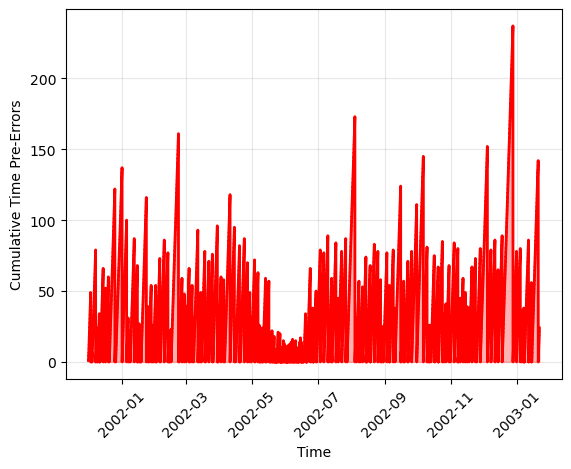

In [21]:
# Convert Timestamp to datetime and sort
df = df.sort_values('Timestamp').reset_index(drop=True)

plt.step(df['Timestamp'], df['timed_errors'], where='post', color='red', linewidth=2)
plt.fill_between(df['Timestamp'], df['timed_errors'], step='post', alpha=0.3, color='red')
plt.xlabel('Time')
plt.ylabel('Cumulative Time Pre-Errors')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

#### Understanding Our Data Through Random Forest Modelling

Here we are:

* Prepping data for modelling (class imbalance, differentiate df on machine type, label encode for multi-class classification)
* Splitting data 80% train, 20% test

**A RandomForest Approach is best suited here for a variety of reasons including:**

* A Reduction in Over-fitting
* The Understanding of interacitons among features
* It is good a dealing with an imbalance in data (K-fold Cross-Validation)

In [23]:
# Adresssing class imbalance issues in dependant variable (failure type)

# Separate the majority and minority classes
df_majority = df[df['Failure Type'] == 'No Failure']
df_minority = df[df['Failure Type'] != 'No Failure']

# Get a list of all unique minority classes
minority_classes = df['Failure Type'].unique()
minority_classes = [cls for cls in minority_classes if cls != 'No Failure']

# Upsample each minority class
upsampled = [df_majority]
for cls in minority_classes:
    df_class = df[df['Failure Type'] == cls]
    df_upsampled = resample(df_class,
                            replace=True,
                            n_samples=len(df_majority),
                            random_state=42)
    upsampled.append(df_upsampled)

# Combine all upsampled data
df_balanced = pd.concat(upsampled)



<Axes: xlabel='Failure Type'>

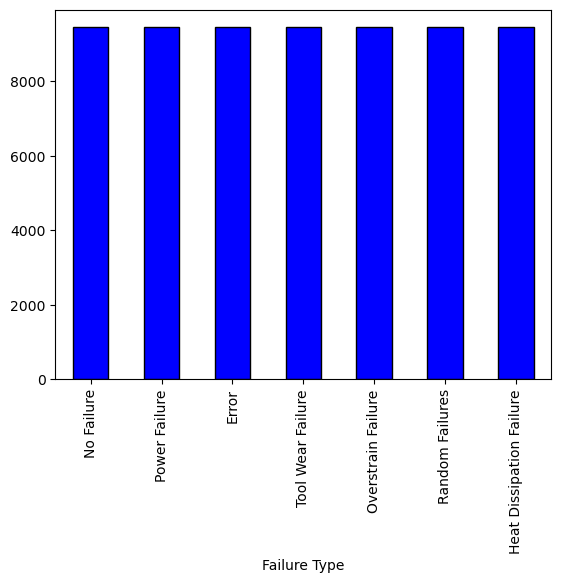

In [24]:
value_counts = df_balanced['Failure Type'].value_counts()
value_counts.plot(kind='bar', color='blue', edgecolor='black')

In [25]:
# Splitting up our data per machine type
machine_types = df_balanced['Machine Type'].unique()
# Create a dictionary to store data per machine type
df_machine = {machine: df_balanced[df_balanced['Machine Type'] == machine].copy() for machine in machine_types}

dfx_1 = df_machine['x_1']
dfx1 = df_machine['x1']
dfX1 = df_machine['X1']

In [26]:
# Setup for random forest mulit-class classification

feature_cols = [
    'Air temperature [K]',
    'Process temperature [K]',
    'Rotational speed [rpm]',
    'Torque [Nm]',
    'Tool wear [min]'
] # Our independant Varaibles

target_col = 'Failure Type' # Our dependant variable

label_enc = LabelEncoder() # for multi-class classification

C:\Users\Sebbr\AppData\Local\Temp\ipykernel_33280\2425594072.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feat_df, palette='flare')


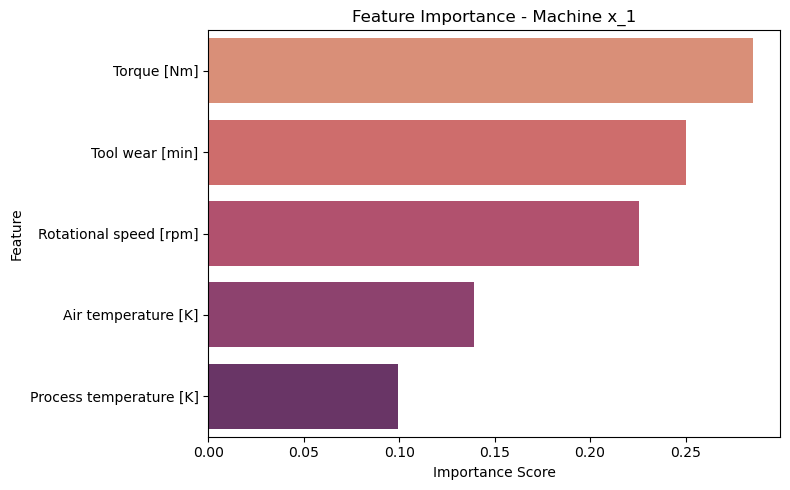

In [27]:
# Random Forest model for machine x_1

Y = label_enc.fit_transform(dfx_1[target_col])
X = dfx_1[feature_cols]

#Splitting the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size= 0.2)

# Hyperparameter tuning - Random Forest
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10]
}

rf = RandomForestClassifier(class_weight='balanced', random_state=42)
search = RandomizedSearchCV(rf, param_distributions=param_grid, n_iter=10, cv=3, scoring='accuracy')
search.fit(X_train, Y_train)

# Predict and evaluate
Y_pred = search.best_estimator_.predict(X_test)
class_rep_x_1 = classification_report(Y_test, Y_pred, target_names=label_enc.classes_)

#Assessing Variable Importance from the model

importances = search.best_estimator_.feature_importances_
features = X.columns

feat_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(x='Importance', y='Feature', data=feat_df, palette='flare')
plt.title('Feature Importance - Machine x_1')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


C:\Users\Sebbr\AppData\Local\Temp\ipykernel_33280\1585088635.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feat_df, palette='flare')


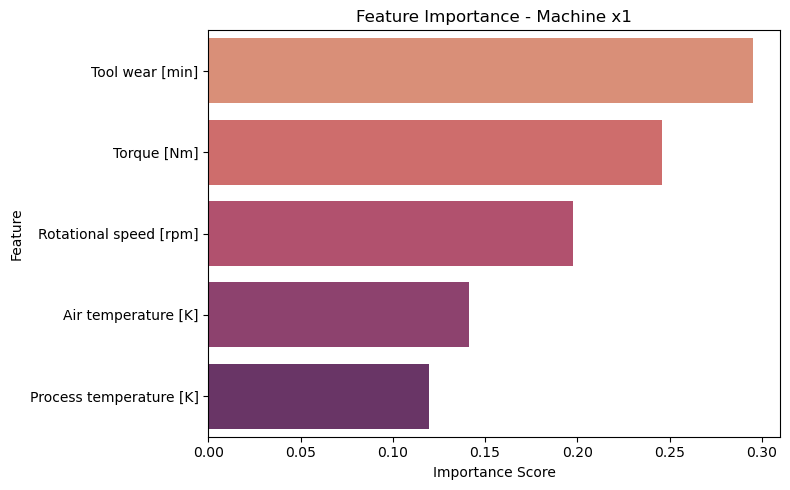

In [28]:
# Random Forest model for machine x1

Y = label_enc.fit_transform(dfx1[target_col])
X = dfx1[feature_cols]

#Splitting the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size= 0.2)

# Hyperparameter tuning - Random Forest
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10]
}

rf = RandomForestClassifier(class_weight='balanced', random_state=42)
search = RandomizedSearchCV(rf, param_distributions=param_grid, n_iter=10, cv=3, scoring='accuracy')
search.fit(X_train, Y_train)

# Predict and evaluate
Y_pred = search.best_estimator_.predict(X_test)
class_rep_x1 = classification_report(Y_test, Y_pred, target_names=label_enc.classes_)

#Assessing Variable Importance from the model

importances = search.best_estimator_.feature_importances_
features = X.columns

feat_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(x='Importance', y='Feature', data=feat_df, palette='flare')
plt.title('Feature Importance - Machine x1')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


C:\Users\Sebbr\AppData\Local\Temp\ipykernel_33280\2512426519.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feat_df, palette='flare')


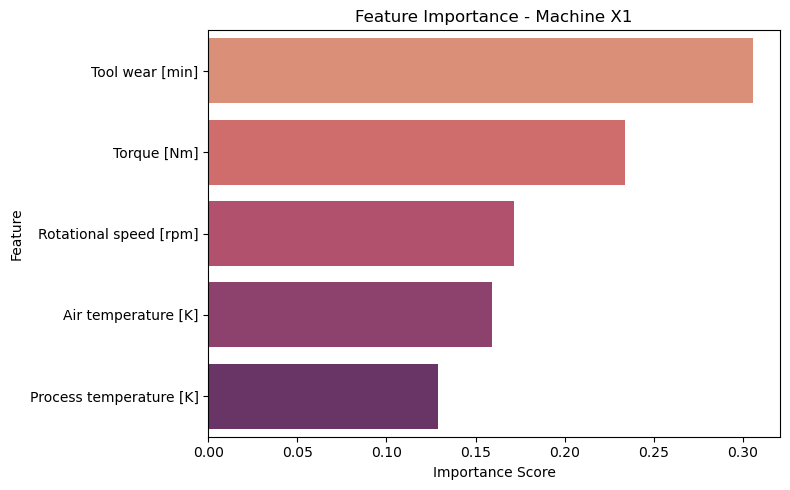

In [29]:
# Random Forest model for machine X1

Y = label_enc.fit_transform(dfX1[target_col])
X = dfX1[feature_cols]

#Splitting the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size= 0.2)

# Hyperparameter tuning - Random Forest
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10]
}

rf = RandomForestClassifier(class_weight='balanced', random_state=42)
search = RandomizedSearchCV(rf, param_distributions=param_grid, n_iter=10, cv=3, scoring='accuracy')
search.fit(X_train, Y_train)

# Predict and evaluate
Y_pred = search.best_estimator_.predict(X_test)
class_rep_X1 = classification_report(Y_test, Y_pred, target_names=label_enc.classes_)

#Assessing Variable Importance from the model

importances = search.best_estimator_.feature_importances_
features = X.columns

feat_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(x='Importance', y='Feature', data=feat_df, palette='flare')
plt.title('Feature Importance - Machine X1')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


#### Understanding the causes of errors through machine learning pt 2

Here we are:

* Understanding what variables contribute to the specific type of errors seen

* thresholds of each varaibles leading to an error i.e if fanspeed reaches above X


C:\Users\Sebbr\AppData\Local\Temp\ipykernel_33280\3947347406.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feat_df, palette='flare')


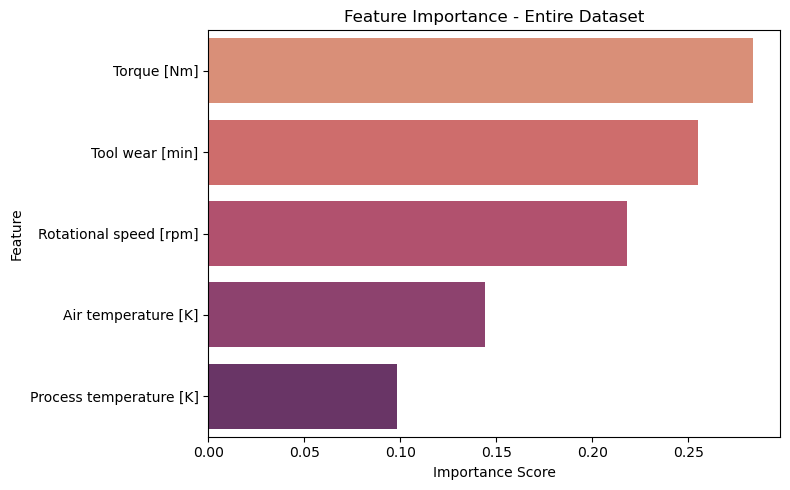

In [31]:
# Random Forest model on entire dataset (cleaned)

feature_cols = [
    'Air temperature [K]',
    'Process temperature [K]',
    'Rotational speed [rpm]',
    'Torque [Nm]',
    'Tool wear [min]',
] # Our independant Variables

target_col = 'Failure Type' # Our dependant variable

Y = label_enc.fit_transform(df_balanced[target_col])
X = df_balanced[feature_cols]

#Splitting the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size= 0.2)

# Hyperparameter tuning - Random Forest
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10]
}

rf = RandomForestClassifier(class_weight='balanced', random_state=42)
search = RandomizedSearchCV(rf, param_distributions=param_grid, n_iter=10, cv=3, scoring='accuracy')
search.fit(X_train, Y_train)

# Predict and evaluate
Y_pred = search.best_estimator_.predict(X_test)
class_rep_glob = classification_report(Y_test, Y_pred, target_names=label_enc.classes_)

#Assessing Variable Importance from the model

importances = search.best_estimator_.feature_importances_
features = X.columns

feat_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(x='Importance', y='Feature', data=feat_df, palette='flare')
plt.title('Feature Importance - Entire Dataset')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


Top features contributing to: Error


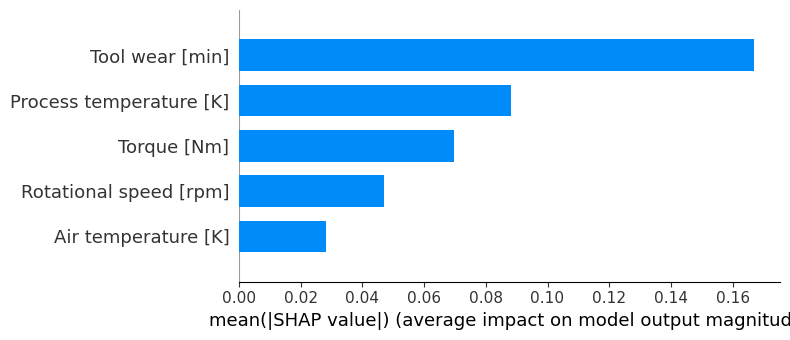


Top features contributing to: Heat Dissipation Failure


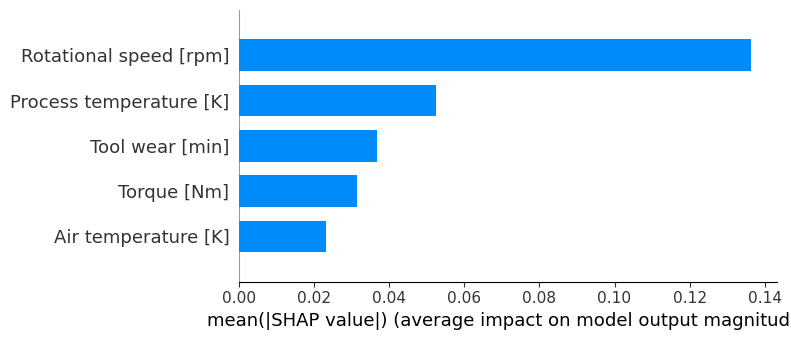


Top features contributing to: No Failure


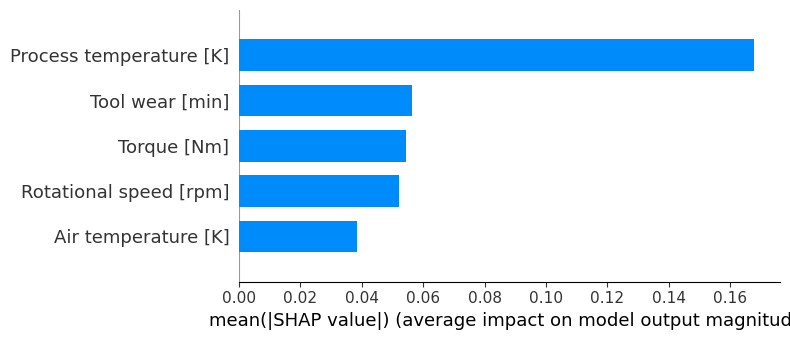


Top features contributing to: Overstrain Failure


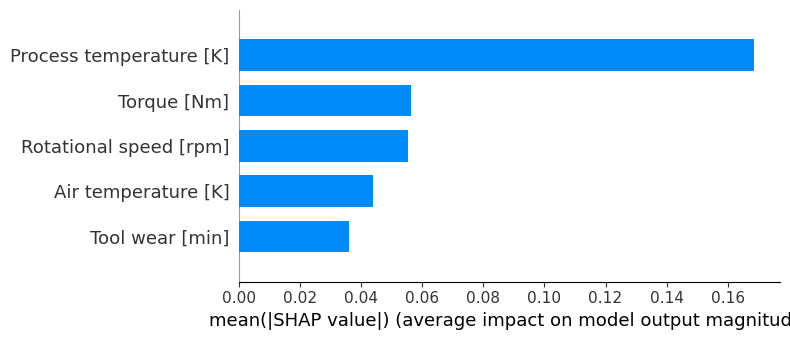


Top features contributing to: Power Failure


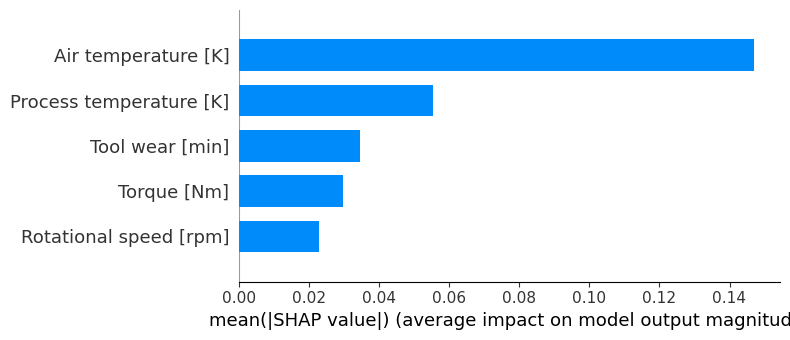


Top features contributing to: Random Failures


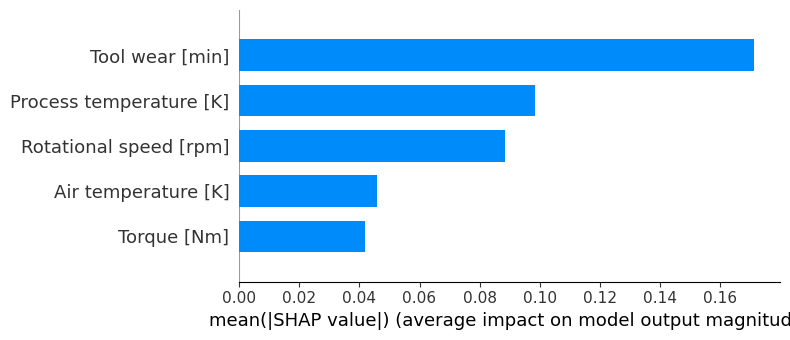


Top features contributing to: Tool Wear Failure


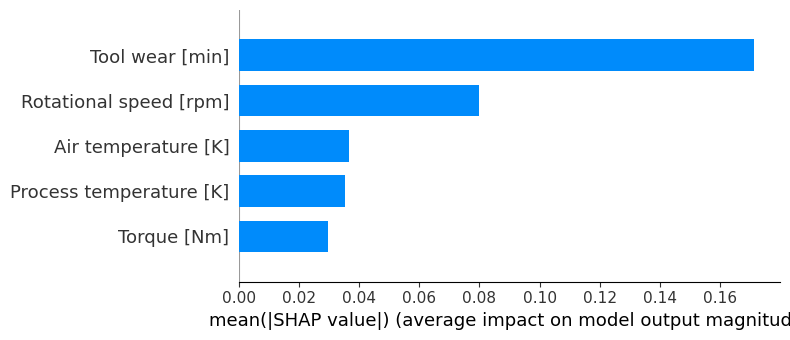

In [32]:
#Using Shap to understand top features associated with each error

# Extract best model
model = search.best_estimator_

# Convert X_test to numpy for SHAP
X_test_array = X_test.values
feature_names = X_test.columns.tolist()

# SHAP explainer
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test_array)

for i, class_name in enumerate(label_enc.classes_):
    print(f"\nTop features contributing to: {class_name}")
    
    sv = shap_values[i]
    if sv.shape[1] != X_test_array.shape[1]:
        sv = sv[:, :X_test_array.shape[1]] 
    shap.summary_plot(sv, X_test_array, feature_names=feature_names, plot_type="bar")


**To get actionable insights we want to**
* Go through every tree in the Random Forest.
  
* For each leaf that ends in a failure prediction, we note the conditions (thresholds) that led there. 

* For each failure type, we count which rules appeared most often — and keep the top few as the most important ones.

In [34]:
def get_model_threshold_table(rf_model, feature_names, class_names, top_k=3): #show top 3 rules (features per failure type)
    all_conditions = []

    for tree in rf_model.estimators_:
        tree_ = tree.tree_
        features = tree_.feature
        thresholds = tree_.threshold
        values = tree_.value

        def traverse(node=0, path=[]): #walks from root node to each leaf
            if features[node] != _tree.TREE_UNDEFINED: #if node is not a leaf we split the data i.e feature found
                # we record values to the left and right of this feature
                traverse(tree_.children_left[node], path + [(features[node], '<=', thresholds[node])])
                traverse(tree_.children_right[node], path + [(features[node], '>', thresholds[node])])
            else:
                class_id = np.argmax(values[node])
                class_name = class_names[class_id]
                for feat_idx, op, thresh in path: #record all conditions that lead to this leaf node
                    all_conditions.append((
                        class_name,
                        feature_names[feat_idx],
                        op,
                        round(thresh, 2)
                    ))

        traverse() # assess each element in data structure

    # Create DataFrame of conditions
    df = pd.DataFrame(all_conditions, columns=['Failure Type', 'Feature', 'Operator', 'Threshold'])

    # Count most frequent rules per class
    summary = (
        df.value_counts()
          .reset_index(name='Count')
          .sort_values(['Failure Type', 'Count'], ascending=[True, False])
          .groupby('Failure Type')
          .head(top_k)
          .reset_index(drop=True)
    )

    return summary

# Run it
threshold_table = get_model_threshold_table(
    rf_model=search.best_estimator_,
    feature_names=feature_cols,
    class_names=label_enc.classes_,
    top_k=3  # Number of top rules per class
)

# Display clean table
threshold_table


,Failure Type,Feature,Operator,Threshold,Count
0,Error,Tool wear [min],<=,197.50,1677
1,Error,Rotational speed [rpm],>,1379.50,1225
2,Error,Torque [Nm],<=,48.75,662
3,Heat Dissipation Failure,Rotational speed [rpm],<=,1379.50,1187
4,Heat Dissipation Failure,Tool wear [min],<=,197.50,620
5,Heat Dissipation Failure,Air temperature [K],>,301.55,620
6,No Failure,Tool wear [min],<=,197.50,4919
7,No Failure,Rotational speed [rpm],>,1379.50,3667
8,No Failure,Rotational speed [rpm],<=,1379.50,2661
9,Overstrain Failure,Tool wear [min],>,197.50,786
